# Building a Modular Forecasting Framework: Fine-Tuning and Predicting Offshore Wind Generation

---

Forecasting energy-related quantities is a critical component of managing renewable energy systems, especially in the context of increasing reliance on wind and solar power. In this series of articles, I detail the development of a scalable MLOps forecasting framework designed to predict energy-related variables for Germany several days ahead. This framework combines open data sources, advanced machine learning models, and a modular, task-based design to ensure reusability and versatility.
In Part 1, I introduced the pipeline for data collection and preprocessing, showcasing how API integrations and preprocessing steps standardize historical and forecasted data for modeling. In Part 2, I implemented baseline forecasting models, including ElasticNet, Prophet, and XGBoost, and developed an ensemble model to improve accuracy. These models were modularized for flexibility.
This article focuses on the next stage: designing an optimized, modular framework for fine-tuning, training, and forecasting. Using offshore wind generation as the target variable, I demonstrate how careful feature engineering, automatic hyperparameter optimization with Optuna, and a task-based approach enable accurate multi-step predictions. By prioritizing modularity and computation efficiency, the framework ensures scalability for forecasting additional energy-related quantities in the future.

---

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import os, gc
import copy
import holidays
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [13]:
data_dir = '../../database/'
target = 'wind_offshore'
# df = pd.read_parquet(data_dir + 'latest.parquet')
df_smard = pd.read_parquet(data_dir + 'smard/' + 'history.parquet')
df_om = pd.read_parquet(data_dir + 'openmeteo/' + 'history.parquet')
df_om_f = pd.read_parquet(data_dir + 'openmeteo/' + 'forecast.parquet')
df_es = pd.read_parquet(data_dir + 'epexspot/' + 'history.parquet')

print(f"SMARD data shapes hist={df_smard.shape} start={df_smard.index[0]} end={df_smard.index[-1]}")
print(f"Openmeteo data shapes hist={df_om.shape} start={df_om.index[0]} end={df_om.index[-1]}")
print(f"Openmeteo data shapes forecast={df_om_f.shape} start={df_om_f.index[0]} end={df_om_f.index[-1]}")
print(f"EPEXSPOT data shapes hist={df_es.shape} start={df_es.index[0]} end={df_es.index[-1]}")

print(f"Target={target} Nans={df_smard[target].isna().sum().sum()}")
# set how to split the dataset
cutoff = df_om_f.index[0]
if cutoff == cutoff.normalize():
    print(f"The cutoff timestamp corresponds to the beginning of the day {cutoff.normalize()}")
print(f"Dataset is split into ({len(df_om[:cutoff])}) before and "
      f"({len(df_om_f[cutoff:])}) ({int(len(df_om_f[cutoff:])/24)} days) after {cutoff}.")
print(df_smard.columns.to_list())

SMARD data shapes hist=(86987, 44) start=2015-01-14 00:00:00+00:00 end=2024-12-16 10:00:00+00:00
Openmeteo data shapes hist=(87265, 55) start=2015-01-01 00:00:00+00:00 end=2024-12-15 00:00:00+00:00
Openmeteo data shapes forecast=(360, 55) start=2024-12-15 00:00:00+00:00 end=2024-12-29 23:00:00+00:00
EPEXSPOT data shapes hist=(80724, 1) start=2015-10-01 00:00:00+00:00 end=2024-12-15 11:00:00+00:00
Target=wind_offshore Nans=0
The cutoff timestamp corresponds to the beginning of the day 2024-12-15 00:00:00+00:00
Dataset is split into (87265) before and (360) (15 days) after 2024-12-15 00:00:00+00:00.
['france_export', 'france_import', 'belgium_export', 'belgium_import', 'switzerland_export', 'switzerland_import', 'czechia_export', 'czechia_import', 'denmark_export', 'denmark_import', 'netherlands_export', 'netherlands_import', 'norway_export', 'norway_import', 'poland_export', 'poland_import', 'sweden_export', 'sweden_import', 'luxembourg_export', 'luxembourg_import', 'austria_export', 'a

## 1. Feature Engineering for Offshore Wind Generation
Accurate forecasting of offshore wind energy generation requires translating raw weather data into features that are more directly related to the physical processes driving wind power. In this project, I developed a preprocessing function to extract and compute critical derived features from weather data for offshore wind farms. The process was guided by literature on renewable energy modeling and tailored specifically for Nordsee Windparks EnBW Hohe See, a prominent offshore wind farm in Germany.

In [14]:
# create combined dataframe
cutoff = df_om_f.index[0]
df_om = df_om.combine_first(df_om_f)
if df_om.isna().any().any():
    print("ERROR! Nans in the dataframe")

def preprocess_openmeteo_for_offshore_wind(df, location_suffix="_hsee")->pd.DataFrame:
    """
    Preprocesses weather data for forecasting offshore wind energy generation.
    Focuses on critical physical features and includes turbulence_intensity, wind_ramp, and wind_shear.
    """

    # 1. Filter for the offshore wind farm location only
    cols_to_keep = [c for c in df.columns if c.endswith(location_suffix)]
    df = df[cols_to_keep].copy()

    # 2. Define key variable columns
    wind_speed_10m_col = f"wind_speed_10m{location_suffix}"
    wind_speed_100m_col = f"wind_speed_100m{location_suffix}"
    wind_dir_100m_col = f"wind_direction_100m{location_suffix}"
    temp_col = f"temperature_2m{location_suffix}"
    press_col = f"surface_pressure{location_suffix}"

    # 3. Compute Air Density (ρ)
    if temp_col in df.columns and press_col in df.columns:
        temp_K = df[temp_col] + 273.15
        R_specific = 287.05  # J/(kg·K) for dry air
        # convert pressure from hPa to Pa
        df["air_density"] = np.array( (df[press_col] * 100.) / (R_specific * temp_K) )

    # 4. Compute Wind Power Density (if wind_speed_100m and air_density are available)
    if wind_speed_100m_col in df.columns and "air_density" in df.columns:
        df["wind_power_density"] = np.array( 0.5 * df["air_density"] * (df[wind_speed_100m_col] ** 3) )

    # 5. Encode Wind Direction (Cyclic)
    if wind_dir_100m_col in df.columns:
        df["wind_dir_sin"] = np.sin(np.deg2rad(df[wind_dir_100m_col]))
        df["wind_dir_cos"] = np.cos(np.deg2rad(df[wind_dir_100m_col]))
        df.drop(columns=[wind_dir_100m_col], inplace=True)

    # 6. Wind Shear (Requires both 10m and 100m wind speeds)
    if wind_speed_10m_col in df.columns and wind_speed_100m_col in df.columns:
        with np.errstate(divide='ignore', invalid='ignore'):
            df["wind_shear"] = np.log(df[wind_speed_100m_col] / df[wind_speed_10m_col]) / np.log(100/10)
        # Replace infinities or NaNs if they occur
        df["wind_shear"].replace([np.inf, -np.inf], np.nan, inplace=True)

    # 7. Turbulence Intensity (using a short rolling window on 100m wind speed)
    if wind_speed_100m_col in df.columns:
        rolling_std = df[wind_speed_100m_col].rolling(window=3, min_periods=1).std()
        rolling_mean = df[wind_speed_100m_col].rolling(window=3, min_periods=1).mean()
        df["turbulence_intensity"] = np.array( rolling_std / rolling_mean )

    # 8. Wind Ramp (difference in 100m wind speed over 1 timestep)
    if wind_speed_100m_col in df.columns:
        df["wind_ramp"] = df[wind_speed_100m_col].diff(1)

    # 9. Lag Features for Wind Speed at 100m
    if wind_speed_100m_col in df.columns:
        for lag in [1, 6, 12, 24]:
            df[f"wind_speed_lag_{lag}"] = df[wind_speed_100m_col].shift(lag)

    # 11. Drop Irrelevant Columns
    # Decide which columns to drop. For model simplicity, consider dropping raw weather inputs
    # that have been transformed into more physical parameters.
    # However, keep wind speeds if you think they add value.
    # For now, we keep the wind speeds since other derived features depend on them.
    drop_vars = [
        temp_col, press_col, "air_density",
        f"precipitation{location_suffix}",
        f"cloud_cover{location_suffix}",
        f"shortwave_radiation{location_suffix}",
        f"relative_humidity_2m{location_suffix}",
        f"wind_direction_10m{location_suffix}",
        f"wind_gusts_10m{location_suffix}"
    ]
    drop_cols = [c for c in drop_vars if c in df.columns]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    # Handle missing values introduced by lagging and other computations
    # df.dropna(inplace=True)

    return df
# Extract data for the offshore wind farm location and create new features
df_om_prep = preprocess_openmeteo_for_offshore_wind(df=df_om, location_suffix="_hsee")
df_om_prep.dropna(inplace=True) # drop nans formed when lagged features were added

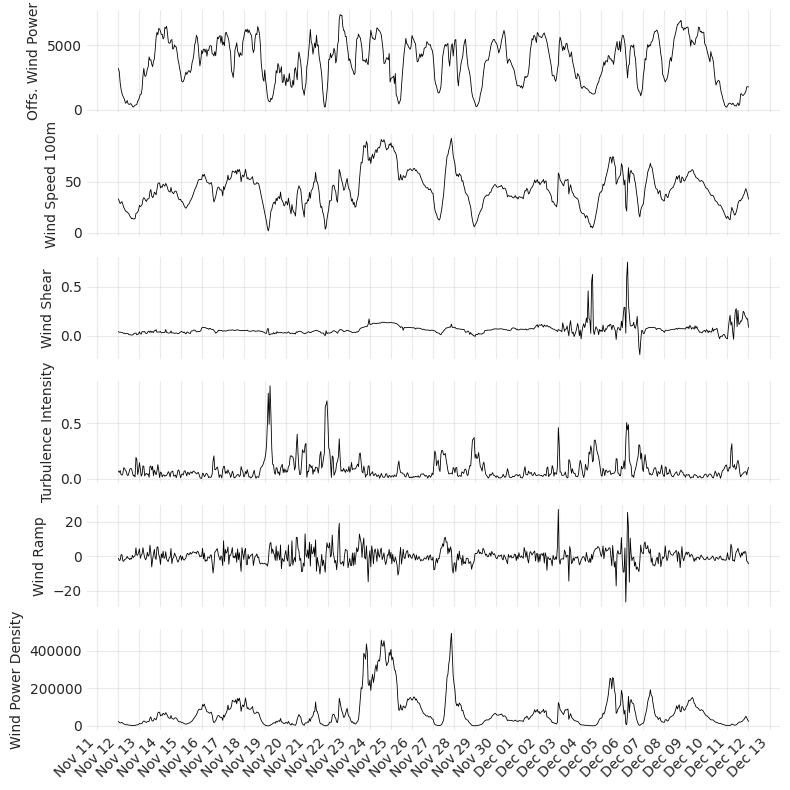

In [4]:
def visualize_weather_smard(df_om_prep_:pd.DataFrame, df_smard_:pd.DataFrame, target:str, ylabel:str):
    fig, axes = plt.subplots(ncols=1, nrows=6, figsize=(8, 8), sharex='all')
    # Plot data
    axes[0].plot(df_smard_.index, df_smard_[target], label=target, color='black', lw=0.6)
    axes[0].set_ylabel(ylabel)

    axes[1].plot(df_om_prep_.index, df_om_prep_["wind_speed_100m_hsee"], label="Wind Speed 100m", color='black', lw=0.6)
    axes[1].set_ylabel("Wind Speed 100m")

    axes[2].plot(df_om_prep_.index, df_om_prep_["wind_shear"], label="Wind Shear", color='black', lw=0.6)
    axes[2].set_ylabel("Wind Shear")

    axes[3].plot(df_om_prep_.index, df_om_prep_["turbulence_intensity"], label="Turbulence Intensity", color='black', lw=0.6)
    axes[3].set_ylabel("Turbulence Intensity")

    axes[4].plot(df_om_prep_.index, df_om_prep_["wind_ramp"], label="Wind Ramp", color='black', lw=0.6)
    axes[4].set_ylabel("Wind Ramp")

    axes[5].plot(df_om_prep_.index, df_om_prep_["wind_power_density"], label="Wind Power Density", color='black', lw=0.6)
    axes[5].set_ylabel("Wind Power Density")

    # Configure transparent axes and add gray gridlines
    for i, ax in enumerate(axes):
        ax.grid(True, linestyle='-', alpha=0.4)
        ax.tick_params(axis='x', direction='in', bottom=True)
        ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)
        # Set border lines transparent by setting the edge color and alpha
        ax.spines['top'].set_edgecolor((1, 1, 1, 0))  # Transparent top border
        ax.spines['right'].set_edgecolor((1, 1, 1, 0))  # Transparent right border
        ax.spines['left'].set_edgecolor((1, 1, 1, 0))  # Transparent left border
        ax.spines['bottom'].set_edgecolor((1, 1, 1, 0))  # Transparent bottom border

        # Make x and y ticks transparent
        ax.tick_params(axis='x', color=(1, 1, 1, 0))  # Transparent x ticks
        ax.tick_params(axis='y', color=(1, 1, 1, 0))  # Transparent y ticks

        if i == len(axes) - 1:
            ax.xaxis.set_major_locator(mdates.DayLocator())
            # ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Dec 15"
        fig.autofmt_xdate(rotation=45)
    plt.tight_layout()
    # plt.savefig('./engineered_features.png',dpi=600)
    plt.show()
visualize_weather_smard(df_om_prep[:cutoff].tail(30*24), df_smard[:cutoff].tail(30*24), target=target, ylabel='Offs. Wind Power')

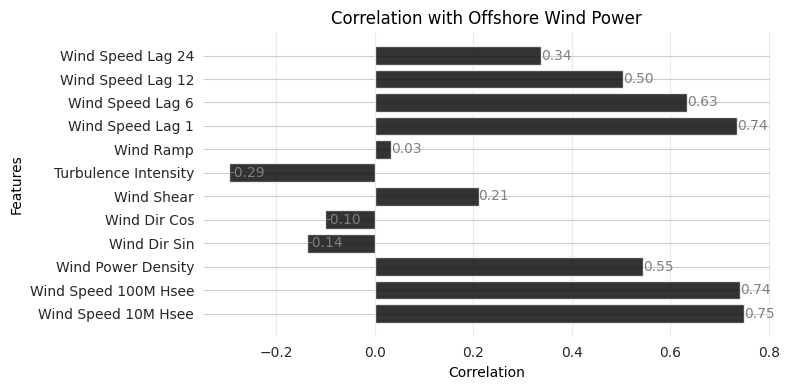

In [5]:
def plot_correlations(df_om_prep_: pd.DataFrame, df_smard_: pd.DataFrame, target: str, label:str):
    # Ensure the target column exists in df_smard_
    if target not in df_smard_.columns:
        raise ValueError(f"Target column '{target}' not found in the provided df_smard_ DataFrame.")

    # Extract the target series
    target_series = df_smard_[target]

    # Compute correlations with predictors in df_om_prep_
    correlations = df_om_prep_.apply(lambda col: col.corr(target_series))

    # Drop NaN values (e.g., if correlation couldn't be computed)
    correlations = correlations.dropna()

    # Format feature names for display
    formatted_feature_names = [
        col.replace('_', ' ').title() for col in correlations.index
    ]

    # Create a figure
    fig, ax = plt.subplots(figsize=(8, 4))

    # Bar plot for correlations
    bars = ax.barh(formatted_feature_names, correlations.values, color='black', alpha=0.8)

    # Add gridlines
    ax.grid(True, linestyle='-', alpha=0.4, axis='x')

    # Set transparent borders
    ax.spines['top'].set_edgecolor((1, 1, 1, 0))
    ax.spines['right'].set_edgecolor((1, 1, 1, 0))
    ax.spines['left'].set_edgecolor((1, 1, 1, 0))
    ax.spines['bottom'].set_edgecolor((1, 1, 1, 0))

    # Set x and y ticks transparent
    ax.tick_params(axis='x', color=(1, 1, 1, 0))
    ax.tick_params(axis='y', color=(1, 1, 1, 0))

    # Add labels and title
    ax.set_xlabel("Correlation", color='black')
    ax.set_ylabel("Features", color='black')
    ax.set_title(f"Correlation with {label}", color='black')

    # Add values on bars
    for bar in bars:
        ax.text(
            bar.get_width(),
            bar.get_y() + bar.get_height() / 2,
            f'{bar.get_width():.2f}',
            va='center',
            ha='left',
            color='gray',
        )

    plt.tight_layout()
    plt.savefig('./feature_target_correlations.png',dpi=600)
    plt.show()
plot_correlations(df_om_prep[:cutoff], df_smard[:cutoff], target=target, label='Offshore Wind Power')


## Task-Based Modular Pipeline

In [6]:
def handle_nans_with_interpolation(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """
    Checks each column of the DataFrame for NaNs. If a column has more than 3 consecutive NaNs,
    it raises a ValueError. Otherwise, fills the NaNs using bi-directional interpolation.
    """

    df_copy = df.copy()

    def check_consecutive_nans(series: pd.Series):
        # Identify consecutive NaNs by grouping non-NaN segments and counting consecutive NaNs
        consecutive_nans = (series.isna().astype(int)
                            .groupby((~series.isna()).cumsum())
                            .cumsum())
        if consecutive_nans.max() > 3:
            raise ValueError(f"Column '{series.name}' in {name} contains more than 3 consecutive NaNs.")

    # Check all columns for consecutive NaNs first
    for col in df_copy.columns:
        check_consecutive_nans(df_copy[col])

    # Interpolate all columns at once after confirming they're valid
    df_copy = df_copy.interpolate(method='linear', limit_direction='both', axis=0)

    return df_copy
def fix_broken_periodicity_with_interpolation(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """
    Fixes broken hourly periodicity by adding missing timestamps if fewer than 3 consecutive are missing.
    Raises an error if more than 3 consecutive timestamps are missing.
    Missing values are filled using time-based interpolation.
    """

    if not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError(f"The DataFrame {name} must have a datetime index.")

    expected_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    missing_timestamps = expected_index.difference(df.index)

    if missing_timestamps.empty:
        print(f"The DataFrame {name} is already hourly with no missing segments.")
        return df

    # Convert to a Series to check consecutive missing timestamps
    missing_series = pd.Series(missing_timestamps)
    groups = (missing_series.diff() != pd.Timedelta(hours=1)).cumsum()

    # Check if any group has more than 3 missing points
    group_counts = groups.value_counts()
    if (group_counts > 3).any():
        bad_group = group_counts[group_counts > 3].index[0]
        raise ValueError(f"More than 3 consecutive missing timestamps detected: "
                         f"{missing_series[groups == bad_group].values} in {name}")

    # Reindex and interpolate
    fixed_df = df.reindex(expected_index)
    fixed_df = fixed_df.interpolate(method='time')

    print(f"Added and interpolated {len(missing_timestamps)} missing timestamps in {name}.")

    return fixed_df
def validate_dataframe(df: pd.DataFrame, name: str = '') -> pd.DataFrame:
    """Check for NaNs, missing values, and periodicity in a time-series DataFrame."""

    # Check for NaNs
    if df.isnull().any().any():
        print(f"ERROR! {name} DataFrame contains NaN values.")
        df = handle_nans_with_interpolation(df, name)

    # Check if index is sorted in ascending order
    if not df.index.is_monotonic_increasing:
        print(f"ERROR! {name} The index is not in ascending order.")
        raise ValueError("Data is not in ascending order.")

    # Check for hourly frequency with no missing segments
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
    if not full_range.equals(df.index):
        print(f"ERROR! {name} The data is not hourly or has missing segments.")
        df = fix_broken_periodicity_with_interpolation(df, name)

    return df

horizon = 7 * 24
# merger with SMRD target column
target = 'wind_offshore'
df_om_prep.dropna(inplace=True, how='any')
df_hist = pd.merge(
    df_om_prep[:cutoff-timedelta(hours=1)],
    df_smard[:cutoff-timedelta(hours=1)][target],
    left_index=True, right_index=True, how="inner"
)
df_forecast = df_om_prep[cutoff : cutoff+timedelta(hours=horizon - 1)]
df_hist = validate_dataframe(df_hist, 'df_hist')
df_forecast = validate_dataframe(df_forecast, 'df_forecast')
df_hist = df_hist[df_hist.index[-1]-pd.Timedelta(hours = 100 * horizon - 1):]
print(f"Features {len(df_hist.columns)-1} hist.shape={df_hist.shape} ({int(len(df_hist)/horizon)}) forecast.shape={df_forecast.shape}")
print(f"Hist: from {df_hist.index[0]} to {df_hist.index[-1]} ({len(df_hist)/horizon})")
print(f"Fore: from {df_forecast.index[0]} to {df_forecast.index[-1]} ({len(df_forecast)/horizon})")

# df_hist.to_parquet(f"{output_dir}history.parquet")
# df_forecast.to_parquet(f"{output_dir}forecast.parquet")

ERROR! df_hist The data is not hourly or has missing segments.
Added and interpolated 4 missing timestamps in df_hist.
Features 12 hist.shape=(16800, 13) (100) forecast.shape=(168, 12)
Hist: from 2023-01-12 00:00:00+00:00 to 2024-12-11 23:00:00+00:00 (100.0)
Fore: from 2024-12-12 00:00:00+00:00 to 2024-12-18 23:00:00+00:00 (1.0)


In [7]:
from forecasting_modules import ForecastingTaskSingleTarget
def main():
    tasks = [
        {
            "target": "wind_offshore",
            "label": "Wind off-shore [MW]",
            "features":[],
            "task_fine_tuning":[
                # {'model':'Prophet',
                #  'dataset_pars':{
                #      'forecast_horizon':None,
                #      'target_scaler':'StandardScaler',
                #      'feature_scaler':'StandardScaler',
                #      'feature_pca_pars' : None,
                #      'limit_pca_to_features':None,#'weather',
                #      'fourier_features' : {'period':24, 'order':3},
                #      'add_cyclical_time_features':True,
                #      'lags_target':None,'log_target':True,
                #      'copy_input':True
                #  },
                # 'finetuning_pars':{'n_trials':120,'optim_metric':'rmse','cv_folds':3}},

                # {'model':'XGBoost',
                #  'dataset_pars':{
                #      'forecast_horizon':None,
                #      'target_scaler':'StandardScaler',
                #      'feature_scaler':'StandardScaler',
                #      'limit_pca_to_features':None,#'weather',
                #      'feature_pca_pars':None,#{'n_components':0.95},
                #      'fourier_features': {},
                #      'add_cyclical_time_features':True,
                #      'lags_target':24,'log_target':True,
                #      'copy_input':True
                #  },
                #  'finetuning_pars':{'n_trials':5,'optim_metric':'rmse','cv_folds':3}},
                #
                # {'model':'ElasticNet',
                #  'dataset_pars':{
                #      'forecast_horizon':None,
                #      'target_scaler':'StandardScaler',
                #      'feature_scaler':'StandardScaler',
                #      'limit_pca_to_features':None,#'weather',
                #      'feature_pca_pars':None,#{'n_components':0.95},
                #      'fourier_features': {},
                #      'add_cyclical_time_features':True,
                #      'lags_target':24,'log_target':True,
                #      'copy_input':True
                #  },
                #  'finetuning_pars':{'n_trials':5,'optim_metric':'rmse','cv_folds':3}},
                #
                # {'model':'ensemble[XGBoost](XGBoost,ElasticNet)',
                #  'dataset_pars': {
                #      'forecast_horizon':None,
                #      'target_scaler':'StandardScaler',
                #      'feature_scaler':'StandardScaler',
                #      'limit_pca_to_features':None,#'weather',
                #      'feature_pca_pars':None,#{'n_components':0.95},
                #      'add_cyclical_time_features':False,
                #      'fourier_features': {},
                #      'ensemble_features': 'cyclic_time',
                #      'log_target':True,
                #      'lags_target': None,
                #      'copy_input':True
                #
                #  },
                #  'finetuning_pars':{'n_trials':5,
                #                     'optim_metric':'rmse',
                #                     'cv_folds':3,
                #                     'cv_folds_base':35,
                #                     'use_base_models_pred_intervals':False}}
            ],
            "task_training":[
                # {'model':'Prophet', 'pars':{'cv_folds':5}},
                {'model':'XGBoost', 'pars':{'cv_folds':5}},
                {'model':'ElasticNet', 'pars':{'cv_folds':5}},
                {'model':'ensemble[XGBoost](XGBoost,ElasticNet)','pars':{'cv_folds':5}},
                {'model':'ensemble[ElasticNet](XGBoost,ElasticNet)','pars':{'cv_folds':5}}
            ],
            "task_forecasting":[
                # {'model':'Prophet'},
                {'model':'XGBoost', 'past_folds':5},
                {'model':'ElasticNet', 'past_folds':5},
                {'model':'ensemble[XGBoost](XGBoost,ElasticNet)','past_folds':5},
                {'model':'ensemble[ElasticNet](XGBoost,ElasticNet)','past_folds':5}
            ],
            "task_plot":[
                # {'model':'Prophet', 'n':2,
                #  'name':"Prophet",'lw':0.7,'color':"red",'ci_alpha':0.0},
                # {'model':'XGBoost','n':2,
                #  'name':'XGBoost','lw':0.7,'color':"green",'ci_alpha':0.0,
                #  'train_forecast':'train'},
                # {'model':'ElasticNet','n':2,
                #  'name':'ElasticNet','lw':0.7,'color':"blue",'ci_alpha':0.0,
                #  'train_forecast':'train'},
                # {'model':'ensemble[XGBoost](XGBoost,ElasticNet)','n':2,
                #  'name':'Ensemble','lw':1.0,'color':"purple",'ci_alpha':0.2,
                #  'train_forecast':'train'},
                # {'model':'ensemble[ElasticNet](XGBoost,ElasticNet)','n':2,
                #  'name':'Ensemble','lw':1.0,'color':"magenta",'ci_alpha':0.2,
                #  'train_forecast':'train'},
            ],
            "task_summarize":[
                # {'model':'Prophet', 'pars':{'cv_folds':5}},
                {'model':'XGBoost', 'summary_metric':'rmse'},
                {'model':'ElasticNet', 'summary_metric':'rmse'},
                {'model':'ensemble[XGBoost](XGBoost,ElasticNet)', 'summary_metric':'rmse'},
                {'model':'ensemble[ElasticNet](XGBoost,ElasticNet)', 'summary_metric':'rmse'},
            ]
        }
    ]

    outdir = '../../forecasting_modules/output/'
    # datapath = '../tmp_database/' # expected to fild history.parquet and forecast.parquet

    if not os.path.isdir(outdir):
        os.mkdir(outdir)

    for task in tasks:
        target = task['target']
        processor = ForecastingTaskSingleTarget(
            df_history=df_hist,df_forecast=df_forecast,task=task,outdir=outdir,verbose=True
        )

        # process task to fine-tune the forecasting model
        if task['task_fine_tuning']:
            for ft_task in task['task_fine_tuning']:
                if ft_task['model'].__contains__('ensemble'):
                    processor.process_finetuning_task_ensemble(ft_task)
                else:
                    processor.process_finetuning_task_base(ft_task)

        # train forecasting model on full dataset assuming hyperparameters are in finetuning dir
        if task['task_training']:
            for t_task in task['task_training']:
                if t_task['model'].__contains__('ensemble'):
                    processor.process_training_task_ensemble(t_task)
                else:
                    processor.process_training_task_base(t_task)

        # forecast with trained model
        if task['task_forecasting']:
            for t_task in task['task_forecasting']:
                if t_task['model'].__contains__('ensemble'):
                    processor.process_forecasting_task_ensemble(t_task)
                else:
                    processor.process_forecasting_task_base(t_task)

        if task['task_plot']:
            processor.process_task_plot_predict_forecast(task)

        if task['task_summarize']:
            processor.process_task_determine_the_best_model(task, outdir=outdir+target+'/')
main()

Given dataset has features: ['wind_speed_10m_hsee', 'wind_speed_100m_hsee', 'wind_power_density', 'wind_dir_sin', 'wind_dir_cos', 'wind_shear', 'turbulence_intensity', 'wind_ramp', 'wind_speed_lag_1', 'wind_speed_lag_6', 'wind_speed_lag_12', 'wind_speed_lag_24', 'wind_offshore']
No features selected for wind_offshore. Using all features: 
['wind_speed_10m_hsee', 'wind_speed_100m_hsee', 'wind_power_density', 'wind_dir_sin', 'wind_dir_cos', 'wind_shear', 'turbulence_intensity', 'wind_ramp', 'wind_speed_lag_1', 'wind_speed_lag_6', 'wind_speed_lag_12', 'wind_speed_lag_24']
Restricting dataframe from 13 features to 12
Setting dataset for base model XGBoost from finetuning directory ../../forecasting_modules/output/wind_offshore/XGBoost/finetuning/
Columns in first DataFrame but missing in forecast df: {'wind_offshore'}
Fitting scaler for 12
Cropping hist dataframe to assume number of rows divisible by horizon: 16776 -> 16632
Data is prepared.
Setting base forecaster XGBoost from directory .

## Automatic Fine-Tuning with Optuna

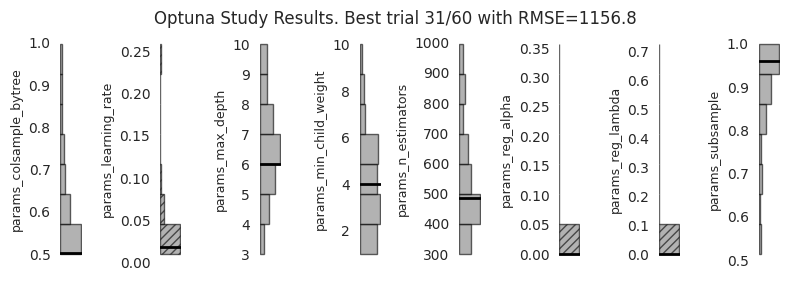

In [8]:
from forecasting_modules.interface import TaskPaths
def load_and_plot_horizontal_histograms(outdir: str):
    """
    Load the complete study results from a CSV file and create horizontal histograms for each parameter.

    Args:
        outdir (str): Path to the directory containing the study results.
    """

    # Load the data
    complete_results_path = os.path.join(outdir, '_complete_study_results.csv')
    if not os.path.isfile(complete_results_path):
        raise FileNotFoundError(f"Complete study results file not found: {complete_results_path}")

    df = pd.read_csv(complete_results_path)

    # Drop irrelevant columns
    if 'state' in df.columns:
        df = df[df['state'] == 'COMPLETE']  # Only consider completed trials
        df.drop(columns=['state'], inplace=True)

    # Determine the best parameter values
    best_params = df.loc[df['value'].idxmin()] if 'value' in df.columns else None

    df.drop(columns=['number', 'value'], inplace=True, errors='ignore')

    # Plot horizontal histograms for each parameter
    num_params = len(df.columns)
    fig, axes = plt.subplots(1, num_params, figsize=(8, 3), sharey=False)

    if num_params == 1:
        axes = [axes]  # Ensure axes is iterable if there's only one parameter

    for ax, column in zip(axes, df.columns):
        data = df[column].dropna()
        # Determine the number of bins based on the number of samples, limited to a maximum
        num_bins = min(50, max(5, int(len(data) ** 0.5)))

        counts, bins, patches = ax.hist(
            data, bins=num_bins, orientation='horizontal', color='gray', edgecolor='black', alpha=0.6
        )
        ax.set_ylabel(column, fontsize=9)  # Move the column name to the y-axis label

        # Check for insufficient exploration (low variance or concentration near bounds)
        is_low_variance = data.std() < (data.max() - data.min()) * 0.1
        is_edge_concentrated = (data < data.min() + (data.max() - data.min()) * 0.1).mean() > 0.5 or \
                               (data > data.max() - (data.max() - data.min()) * 0.1).mean() > 0.5
        if is_low_variance or is_edge_concentrated:
            for patch in patches:
                patch.set_hatch('////')  # Add hashing to the histogram boxes

        # Find the largest bin and annotate it
        max_count_idx = counts.argmax()
        max_count = counts[max_count_idx]
        bin_center = (bins[max_count_idx] + bins[max_count_idx + 1]) / 2
        # ax.text(max_count, bin_center, str(int(max_count)), ha='left', va='center', fontsize=8, color='black')

        # Add a horizontal line at the best parameter value if available
        if best_params is not None and column in best_params:
            best_value = best_params[column]
            ax.axhline(y=best_value, color='black', linestyle='-', linewidth=2)#, label='Best Value')
            # ax.legend(fontsize=8)


        # Remove x-axis ticks and labels
        ax.set_xticks([])
        ax.grid(color='white')

        # Remove axis lines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    fig.suptitle(f"Optuna Study Results. Best trial {int(best_params['number'])}/{len(df)} with RMSE={best_params['value']:.1f}", fontsize=12, y=0.92)

    plt.tight_layout()
    plt.savefig('./optuna_study_result.png', dpi=600)
    plt.show()
path = TaskPaths(target=target, model_label='XGBoost',working_dir='../../forecasting_modules/output/',verbose=True)
load_and_plot_horizontal_histograms(outdir=path.to_finetuned())

In [9]:
from forecasting_modules import compute_timeseries_split_cutoffs, compute_error_metrics
working_dir = f'../../forecasting_modules/output/'
cutoffs = compute_timeseries_split_cutoffs(
    df_hist.index,
    horizon=len(df_forecast.index),
    delta=len(df_forecast.index),
    folds=5,
    min_train_size=30*24
)
smard_res = []
results = {}
smard_metrics = {}
for i, cutoff in enumerate(cutoffs):
    mask = (df_hist.index >= cutoff) & (df_hist.index < cutoff + pd.Timedelta(hours=len(df_forecast.index)))
    mask_ = (df_smard.index >= cutoff) & (df_smard.index < cutoff + pd.Timedelta(hours=len(df_forecast.index)))
    actual = df_hist[target][mask]
    predicted = df_smard[f"{target}_forecasted"][mask_]
    # print(f"{predicted.index[0]}")
    # print(f"\t{predicted.index[-1]}")
    df = pd.DataFrame({
        f'{target}_actual':actual.values,
        f'{target}_fitted': predicted.values,
        f'{target}_lower': np.zeros_like(actual.values),
        f'{target}_upper': np.zeros_like(actual.values)
    }, index=actual.index)
    smard_res.append(copy.deepcopy(df))
    smard_metrics[cutoff] = compute_error_metrics(target, df)

smard_metrics_ = [smard_metrics[key] for key in smard_metrics.keys()]
ave_metrics = {
    key: np.mean( [smard_metrics_[i][key] for i in range(len((smard_metrics_)))] ) for key in list(smard_metrics_[0].keys())
}
smard_metrics_.append(ave_metrics)

## Results and Evaluation

dict_keys([Timestamp('2024-11-07 00:00:00+0000', tz='UTC'), Timestamp('2024-11-14 00:00:00+0000', tz='UTC'), Timestamp('2024-11-21 00:00:00+0000', tz='UTC'), Timestamp('2024-11-28 00:00:00+0000', tz='UTC'), Timestamp('2024-12-05 00:00:00+0000', tz='UTC')])
dict_keys([Timestamp('2024-11-07 00:00:00+0000', tz='UTC'), Timestamp('2024-11-14 00:00:00+0000', tz='UTC'), Timestamp('2024-11-21 00:00:00+0000', tz='UTC'), Timestamp('2024-11-28 00:00:00+0000', tz='UTC'), Timestamp('2024-12-05 00:00:00+0000', tz='UTC')])


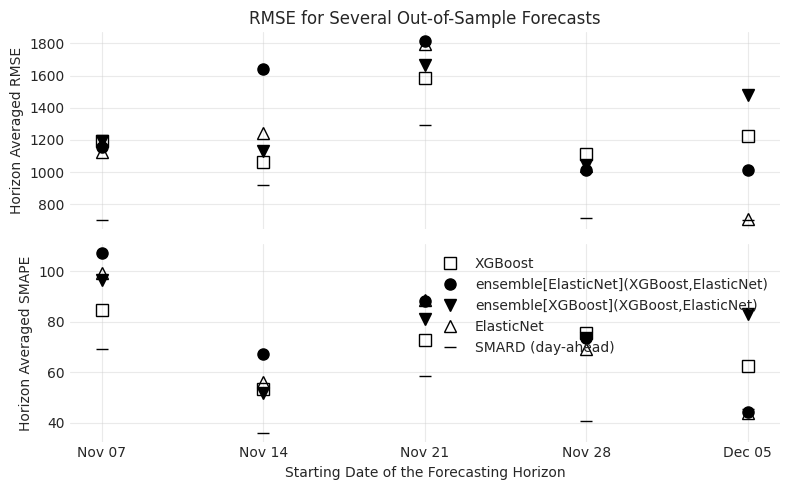

In [10]:
def plot_metric_evolutions(file_path: str, metrics: list, smard_metrics:dict or None):
    # Load the dataframe
    df = pd.read_csv(file_path)

    # Filter relevant columns
    for metric in metrics:
        if metric not in df.columns:
            raise ValueError(f"Metric '{metric}' not found in the dataframe.")

    # Sort the dataframe by horizon and convert horizon to datetime
    df['horizon'] = pd.to_datetime(df['horizon'])
    df = df.sort_values(by='horizon')

    markers = ['s', 'o', 'v', '^', 'P']

    # Plot the metric evolution
    fig, axes = plt.subplots(figsize=(8, 2*len(metrics)+1), ncols=1, nrows=len(metrics), sharex=True, sharey=False)
    if not hasattr(axes, '__len__'): axes = [axes]
    for i, (metric, ax) in enumerate(zip(metrics, axes)):
        for marker, model_label in zip(markers, df['model_label'].unique()):
            if model_label.__contains__('ensemble'): markerfacecolor = 'black'
            else: markerfacecolor = 'None'
            method_df_trained = df[(df['model_label'] == model_label) & (df['method'] == 'trained')]
            ax.plot(method_df_trained['horizon'], method_df_trained[metric], linestyle='None',
                    marker=marker, label=model_label, color='black',
                    markerfacecolor=markerfacecolor, markeredgecolor='black', markersize=8
                    )
            # method_df_forecast = df[(df['model_label'] == model_label) & (df['method'] == 'trained')]
            # ax.plot(method_df_forecast['horizon'], method_df_forecast[metric], linestyle='None', marker=marker)
        if smard_metrics is not None:
            print(smard_metrics.keys())
            ax.plot(
                pd.to_datetime(list(smard_metrics.keys())),
                [smard_metric[metric] for smard_metric in smard_metrics.values()],
                linestyle='None',
                marker='_',
                label='SMARD (day-ahead)',
                color='black',
                markerfacecolor='black',
                markeredgecolor='black',
                markersize=8
            )
        # Set x-ticks at unique horizon values
        unique_horizons = df['horizon'].sort_values().unique()
        ax.set_xticks(unique_horizons)
        ax.set_xticklabels([
            h.strftime('%Y-%m-%d') for h in unique_horizons], rotation=0, ha='center'#'right'
        )

        ax.grid(True, linestyle='-', alpha=0.4)
        ax.tick_params(axis='x', direction='in', bottom=True)
        ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)
        # Set border lines transparent by setting the edge color and alpha
        ax.spines['top'].set_edgecolor((1, 1, 1, 0))  # Transparent top border
        ax.spines['right'].set_edgecolor((1, 1, 1, 0))  # Transparent right border
        ax.spines['left'].set_edgecolor((1, 1, 1, 0))  # Transparent left border
        ax.spines['bottom'].set_edgecolor((1, 1, 1, 0))  # Transparent bottom border

        # Make x and y ticks transparent
        ax.tick_params(axis='x', color=(1, 1, 1, 0))  # Transparent x ticks
        ax.tick_params(axis='y', color=(1, 1, 1, 0))  # Transparent y ticks

        # ax.xaxis.set_major_locator(mdates.DayLocator())
        # ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Dec
        if i == 0:
            ax.set_title(f"{metric.upper()} for Several Out-of-Sample Forecasts")
        if i == len(metrics)-1:
            ax.legend(fancybox=False, frameon=False,loc='upper right')
            ax.set_xlabel("Starting Date of the Forecasting Horizon")
        ax.set_ylabel(f"Horizon Averaged {metric.upper()}")
        ax.grid(True)
    plt.tight_layout()
    plt.savefig(file_path.replace(".csv",".png"), dpi=600)
    plt.show()
plot_metric_evolutions(working_dir+target+'/summary_metrics.csv', metrics=['rmse','smape'], smard_metrics=smard_metrics)

In [11]:
from forecasting_modules import ForecastingTaskSingleTarget
# Load our past and current forecasts
forecast_res:dict = ForecastingTaskSingleTarget._load_trained_model(
    target=target,
    model_label='ensemble[ElasticNet](XGBoost,ElasticNet)',#"ensemble[ElasticNet](XGBoost,ElasticNet)",#'ensemble[XGBoost](XGBoost,ElasticNet)',
    working_dir=working_dir,
    train_forecast='train',
    verbose=True
)

n = 4 # number of windows to show

smard_forecast:pd.DataFrame = copy.deepcopy(smard_res[-1])
smard_forecast[:] = 0 # unknown, as SMARD does not provide week-ahead forecast from now
tasks = [
    {'model':'SMARD','n':n,'name':'TSO day-ahead forecast','lw':1.0,'color':'blue','ci_alpha':0.0,
     'results':smard_res[-n:],'metrics':smard_metrics_[-n-1:],'forecast':None,'ahead':'day'}, #
    {'model':'XGBoost','n':n,'name':'Our week-ahead forecast','lw':1.0,'color':'red','ci_alpha':0.0,
     'results':forecast_res['results'][-n:],'metrics':forecast_res['metrics'][-n-1:],'forecast':None,'ahead':'week'} # forecast_res['forecast']
]

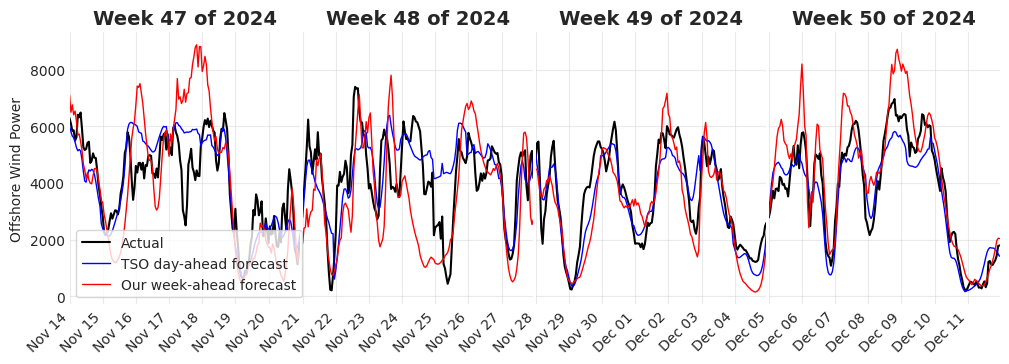

In [12]:
def plot_time_series_with_residuals(tasks: list[dict], target: str = 'total_grid_load', ylabel: str = '',**kwargs):
    '''

    Plots forecasts split into adjacent windows. Each window can show several forecasts performed with
    different methods listed in 'tasks', where each entry is a dictionary with 'results', 'metrics' and 'forecast'.
    Last panel shows the latest forecast (as given in 'forecast' in tasks) and last metrics from 'metrics' in tasks.
    Bottom panels show residuals between actual target variable and forecasted.

    :param tasks: list[dict] where each dict represents a model's forecasting results that consist of
    - tasks[0]['results']:list[pd.DataFrame] list of forecasts for past forecasting winows where each dataframe has:
    f'{target}_actual', f'{target}_fitted', f'{target}_lower', 'f'{target}_upper'
    - tasks[0]['metrics]:list[dict] list of performance metrics for each forecasted window (RMSE,sMAPE...) where the last
    element in the list contains the average metrics
    tasks[0]['forecast']:pd.Dataframe -- same as dataframes in 'results' but with the current latest forecast
    :param target: str target name
    :param label: y-label for the top panels
    :param kwargs: additional arguments for plotting
    :return: None
    '''

    plot_residuals = False
    if 'residuals' in kwargs:
        plot_residuals = kwargs['residuals']

    legends_per_panel = False
    if 'legends_per_panel' in kwargs:
        legends_per_panel = kwargs['legends_per_panel']

    label_errs = True
    if 'label_errs' in kwargs:
        label_errs = kwargs['label_errs']

    if 'watermark' in kwargs:
        watermark_text = kwargs['watermark']
    else:
        watermark_text = None

    if 'itime' in kwargs:
        itime = kwargs['itime']
    else:
        itime = None

    # Determine the maximum number of results across tasks
    plot_forecast = False
    for task in tasks:
        if task['forecast']:
            plot_forecast = True

    max_n_results = max(len(task['results']) for task in tasks)
    if plot_forecast: n_cols = max_n_results + 1  # Plus one for 'forecast'
    else: n_cols = max_n_results


    if not 'drawstyle' in kwargs: drawstyle='default'
    else: drawstyle=kwargs['drawstyle']

    # Create figure and axes
    fig, axes = plt.subplots(
        nrows = 2 if plot_residuals else 1, ncols=n_cols,
        figsize=kwargs['figsize'] if 'figsize' in kwargs else (n_cols * 5, 8),
        gridspec_kw={
            'height_ratios': [3, 1] if plot_residuals else [1],
            'hspace': 0.02, 'wspace': 0.01
        },
        sharex='col', sharey='row'
    )

    # Define column names
    actual_col = f'{target}_actual'
    fitted_col = f'{target}_fitted'
    lower_col = f'{target}_lower'
    upper_col = f'{target}_upper'

    # For each column

    for i in range(n_cols):
        ax_top = axes[0, i] if plot_residuals else axes[i]
        ax_bottom = axes[1, i] if plot_residuals else None

        # Flag to check if 'Actual' data has been plotted
        actual_plotted = False

        # For each task
        for task in tasks:
            name = task['name']
            color = task['color']
            ci_alpha=task['ci_alpha']
            lw=task['lw']
            # Determine if the task has data for this column
            if i < len(task['results']):
                df = task['results'][i]
                errs = task['metrics'][i]
            elif i == max_n_results:
                df = task['forecast']
                errs = task['metrics'][i]
            else:
                continue  # Skip plotting for this task in this column

            if itime is not None:
                itime_:int = itime - i * len(df)
                if itime_ > len(df) - 1: itime_ = len(df)-1
                if itime_ < 0: itime_ = 0
                mask_actual = df.index <= df.index[itime_]

                if task['ahead'] == 'day': itime__ = min(itime_+24 if itime_>0 else 0, len(df)-1)
                elif task['ahead'] == 'week': itime__ = min(itime_+7*24 if itime_>0 else 0, len(df)-1)
                else:raise KeyError(f'Unrecognized forecast model for index offset')
                mask_forecast = df.index <= df.index[itime__]
            else:
                mask_actual = df.index <= df.index[-1]
                mask_forecast = df.index <= df.index[-1]

            # Plot 'Actual' data once per subplot
            if not actual_plotted : #and i != n_cols-1:
                ax_top.plot(df[mask_actual].index, df[mask_actual][actual_col],
                            label='Actual', color='black', drawstyle=drawstyle, lw=1.5)
                actual_plotted = True

            # Plot fitted data
            if label_errs and (errs is not None and i != n_cols-1):
                label = name + ' '  fr"RMSE={errs['rmse']:.1f}" + fr" sMAPE={errs['smape']:.1f}"
            elif label_errs:
                label = name + ' ' fr"$\langle$RMSE$\rangle$={errs['rmse']:.1f}" \
                        + fr" $\langle$sMAPE$\rangle$={errs['smape']:.1f}"
            else:
                label = name
            ax_top.plot(df[mask_forecast].index, df[mask_forecast][fitted_col],
                        label=label, color=color, drawstyle=drawstyle, lw=lw)

            # Plot confidence intervals
            if ci_alpha > 0.:
                ax_top.fill_between(
                    df[mask_forecast].index, df[mask_forecast][lower_col], df[mask_forecast][upper_col],
                    color=color, alpha=ci_alpha
                )

            # Plot residuals in the bottom panel
            residuals = (df[actual_col] - df[fitted_col]) #/ df[actual_col]
            if ax_bottom: ax_bottom.plot(df[mask_actual].index, residuals[mask_actual], label=name, color=color, drawstyle=drawstyle, lw=lw)

            # limit plots
            ax_top.set_xlim(df.index.min(),df.index.max())
            if ax_bottom: ax_bottom.set_xlim(df.index.min(),df.index.max())
            if 'ylim0' in kwargs: ax_top.set_ylim(kwargs['ylim0'][0], kwargs['ylim0'][1])
            if 'ylim1' in kwargs and ax_bottom: ax_bottom.set_ylim(kwargs['ylim1'][0], kwargs['ylim1'][1])

        # print(f"N={len(df.index)} idx0={df.index[0].isoformat()}")
        # Add a horizontal line at y=0 in residuals plot
        if ax_bottom: ax_bottom.axhline(0, color='gray', linestyle='--', linewidth=1)

        # Set titles and labels
        if itime and itime_ > 0:
            if i < max_n_results:
                ax_top.set_title(f'Week {df.index[-1].isocalendar().week} of 2024', fontsize=14, weight='bold')
            else:
                ax_top.set_title('Current Forecast', fontsize=14, weight='bold')


        if ylabel and i == 0:
            ax_top.set_ylabel(ylabel)
            if ax_bottom: ax_bottom.set_ylabel('Residual / Actual')

        # legend in the empty area in residual plots
        if i == n_cols - 1 and ax_bottom:
            ax_bottom.legend(loc='upper left', ncol=1, fontsize=10)

        if legends_per_panel or i==0:#i == n_cols - 1:
            ax_top.legend(loc='lower left', ncol=1, fontsize=10)

        if watermark_text and i == n_cols-1:
            ax_top.text(0.1, 0.1, watermark_text, transform=ax_top.transAxes,
                        fontsize=40, color='gray', alpha=0.2,
                        ha='center', va='center', rotation=0)

        for ax in [ax_top, ax_bottom] if plot_residuals else [ax_top]:
            ax.grid(True, linestyle='-', alpha=0.4)
            ax.tick_params(axis='x', direction='in', bottom=True)
            ax.tick_params(axis='y', which='both', direction='in', left=True, right=True)
            # Set border lines transparent by setting the edge color and alpha
            ax.spines['top'].set_edgecolor((1, 1, 1, 0))  # Transparent top border
            ax.spines['right'].set_edgecolor((1, 1, 1, 0))  # Transparent right border
            ax.spines['left'].set_edgecolor((1, 1, 1, 0))  # Transparent left border
            ax.spines['bottom'].set_edgecolor((1, 1, 1, 0))  # Transparent bottom border

            # Make x and y ticks transparent
            ax.tick_params(axis='x', color=(1, 1, 1, 0))  # Transparent x ticks
            ax.tick_params(axis='y', color=(1, 1, 1, 0))  # Transparent y ticks

            # Make x and y tick labels transparent
            # for tick_label in ax.get_xticklabels():
            #     tick_label.set_color((1, 1, 1, 0))  # Transparent x tick labels
            # for tick_label in ax.get_yticklabels():
            #     tick_label.set_color((1, 1, 1, 0))  # Transparent y tick labels


        # Improve x-axis formatting
        # ax_bottom.set_xlabel(f'Date (month-day for $2024$)', fontsize=12)
        if ax_bottom:
            ax_bottom.xaxis.set_major_locator(mdates.DayLocator())
            # ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Dec 15"
        else:
            ax_top.xaxis.set_major_locator(mdates.DayLocator())
            # ax_bottom.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
            ax_top.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))  # Format as "Dec 15"
        fig.autofmt_xdate(rotation=45)


    model_names = "".join(task["name"]+'_' for task in tasks)
    if 'fpath' in kwargs:
        plt.savefig(kwargs['fpath'], bbox_inches='tight')
    else:
        plt.savefig(f'{target}_{model_names}.png', bbox_inches='tight')
    if 'show' in kwargs and kwargs['show']: plt.show()

    plt.close(fig)
    gc.collect()

# Usage: Just call this function similarly to your existing plotting call
plot_time_series_with_residuals(
    tasks, target=target, ylabel='Offshore Wind Power',
    residuals = False, legends_per_panel=False, label_errs=False, figsize=(12,4),
    show=True,
    itime = 900, fpath = "./results.png" #fpath=os.getcwd()+'/'+'movie'+'/'+f"{i:03}.png",
)